## 1. Introduction, Motivation and Problem Statement
lmage segmentation plays a pivotal role in numerous computer vision applications, including medical imaging, autonomous driving, and satellite imagery analysis. By dividing an image into semantically meaningful regions, image segmentation enables more accurate object detection and recognition, leading to advancements in various fields. 


The application of image segmentation techniques in the context of autonomous driving has gained significant attention in recent years. Accurate identification and delineation of various objects and road elements are critical for ensuring the safety and efficiency of autonomous vehicles. 


This project focuses on the evaluation of three prominent image segmentation methods-U-net, Segnet, and deeplabv3-in the context of a comprehensive dataset he assessment aims to provide valuable insights into the efficacy of these methods and their potential implications for enhancing the capabilities of autonomous driving systems.


The primary objective of this project is to explore the efficacy of various image segmentation techniques, namely Unet, Segnet, and deeplabv3, in the context of autonomous driving. The importance of this problem lies in the critical role played by accurate image segmentation in enhancing the perception capabilities of autonomous vehicles, thereby ensuring their safe and efficient operation in complex real-world environments. The proposed solution aims to contribute to the advancement of current practices by evaluating the performance of these state-of-the-art models in accurately identifying and segmenting various objects and elements crucial for autonomous driving, such as lanes, vehicles, pedestrians, and traffic signs. 

In [12]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
from torchvision.transforms.functional import to_pil_image
import cv2

## 2. Data source or RL Tasks
The IDD 20K dataset is a curated collection of images for autonomous driving research, featuring a variety of road scenes, traffic signs, pedestrians, and vehicles. 


Initially comprising 5,966 training images and 1,016 validation images, the dataset has been enhanced with preprocessing and data augmentation to include around 3,000 additional images, ensuring a broad representation of scenarios for image segmentation model training. 


Strict quality control measures have been applied to maintain data relevance and accuracy. The dataset is publicly available for download at Kaggle: https://www.kaggle.com/datasets/abhishekprajapat/idd-20k/data

In [2]:
#define dataset

input_height = 512
input_width = 512
n_classes = 27

class SegDataset(Dataset):
    def __init__(self, txt_file, image_folder, label_folder, transform=None, label_transform=None):
        with open(txt_file, "r") as f:
            self.lines = f.readlines()
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.label_transform = label_transform if label_transform is not None else transforms.Compose([
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
        ])

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        img_name, label_name = self.lines[idx].strip().split(';')
        img = Image.open(os.path.join(self.image_folder, img_name))
        label = Image.open(os.path.join(self.label_folder, label_name))
        if self.transform:
            img = self.transform(img)
        if self.label_transform:
            label = self.label_transform(label)
        label = np.array(label, dtype=np.int32)
        label[label == 255] = 26
        label = torch.from_numpy(label).long()  # Convert numpy array to torch LongTensor
        return img, label
    
    
train_transform = transforms.Compose([
    transforms.Resize((input_height, input_width)),  # Resize images to the required input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
     
])

# Define transformations for the test set 
test_transform = transforms.Compose([
    transforms.Resize((input_height, input_width)),  # Resize images to the required input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
     
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
])


## 3. Exploratory Analysis of Data or RL Tasks

The dataset utilized in our segmentation model has a resolution of 512x512 pixels and comprises 27 distinct classes for various elements typically found in autonomous driving scenes. Additionally, there is a special consideration in our dataset where the pixel value of 255 represents "unlabeled/out of region of interest (ROI)" data. In preparation for the training of our segmentation model, we conducted several preprocessing steps. Our dataset was augmented with noise and complexity to simulate realistic and challenging scenarios encountered in autonomous driving.


During preprocessing, we handled the special case of the pixel value 255 by treating it as a separate class, using the ignore_index parameter set to 26 in the nn.CrossEntropyLoss function. This approach allows our model to effectively ignore the "unlabeled/ROI" pixels during the loss calculation, preventing them from adversely affecting the training process.
The preprocessing steps applied to the images include resizing to the required input size and converting images to PyTorch tensors. We also applied a similar resizing transformation to the labels, ensuring that the pixel value 255 is reassigned to class 26, thus maintaining consistency across our data.


The dataset is loaded using a custom SegDataset class, which applies these transformations to the images and labels. The images are resized according to the specified input_height and input_width before being converted to tensors. Labels undergo a resizing step to ensure they match the output dimensions expected by the network.
The training loop involves the standard procedures of zeroing the gradients, performing a forward pass, calculating the loss, and then updating the model weights through backpropagation. We track the running loss and accuracy, outputting these metrics periodically to monitor the model's performance.


Overall, the chosen preprocessing techniques are designed to enhance the model's robustness to noise and complex scenes, which are common in real-world autonomous driving applications. By treating the "unlabeled/ROI" data as a separate class for the purposes of loss calculation, we aim to improve the model's accuracy in predicting the relevant classes.

In [3]:
from segnet_model import SegNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = SegDataset(
    txt_file="./dataset2/train.txt",
    image_folder="./dataset2/jpg",
    label_folder="./dataset2/png",
    transform=train_transform,
    label_transform=label_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
model = SegNet(input_channels=3, n_classes=27).to(device)
if torch.cuda.is_available():
    model = model.cuda()
criterion = nn.CrossEntropyLoss(ignore_index=26)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
weights_folder = './logs/'
best_accuracy = 0.0
weight_path = 'logs/best_model.pth'
#model.load_state_dict(torch.load(weight_path))


## 4. Models and/or Methods:
In this project, the SegNet model was selected for its efficacy in road scene detection, which is a crucial component of autonomous driving systems. but U-Net,  excels in medical image segmentation due to its fine-grained localization capabilities, SegNet provides a balance between detail and computational efficiency, making it better suited for the high variability found in road conditions and larger scene understanding.

For the implementation, we used CUDA for acceleration to enhance computational performance, allowing for faster model training and iteration. The model optimization is handled by the Adam optimizer, renowned for its efficiency in converging by adjusting learning rates dynamically. A batch size of 4 was chosen to optimize GPU memory usage while allowing for sufficient gradient estimation during backpropagation. The initial learning rate we set 1e-3,and training epochs are 15.

No pre-trained weights were utilized in this model to ensure the learning process was tailored specifically to our unique dataset and tasks. This choice was made to avoid biases that could be introduced by pre-trained models on dissimilar datasets.

The entirety of the project, except the fundamental SegNet architecture, represents original work. This includes the preprocessing of data, the preparation of the dataset, the design of the experiment, the training procedure, and the subsequent analysis of results. By designing a system from the ground up, we maintain full control over the variables and ensure that the outcomes are a direct result of our method choices and data characteristics.

The method decisions—from the choice of model to the specifics of the implementation—were made with careful consideration of the project's objectives, the nature of the data, and the required computational efficiency.

In [4]:
for epoch in range(15):
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    for i, data in enumerate(tqdm(train_loader), 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.numel()


    end_time = time.time()
    epoch_time = end_time - start_time
    epoch_accuracy = 100. * correct / total
    print('Epoch [%d] finished, time: %.3fs, loss: %.3f, accuracy: %.3f' %
          (epoch + 1, epoch_time, running_loss / (i + 1), epoch_accuracy))

    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), os.path.join(weights_folder, 'epoch_%d.pth' % (epoch + 1)))

    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(model.state_dict(), os.path.join(weights_folder, 'best_model.pth'))

100%|██████████| 1492/1492 [07:38<00:00,  3.25it/s]


Epoch [1] finished, time: 458.711s, loss: 1.141, accuracy: 67.038


100%|██████████| 1492/1492 [07:20<00:00,  3.39it/s]


Epoch [2] finished, time: 440.452s, loss: 0.890, accuracy: 72.916


100%|██████████| 1492/1492 [08:16<00:00,  3.00it/s]


Epoch [3] finished, time: 496.789s, loss: 0.770, accuracy: 75.924


100%|██████████| 1492/1492 [07:58<00:00,  3.12it/s]


Epoch [4] finished, time: 478.686s, loss: 0.697, accuracy: 77.918


100%|██████████| 1492/1492 [07:27<00:00,  3.33it/s]


Epoch [5] finished, time: 447.948s, loss: 0.646, accuracy: 79.350


100%|██████████| 1492/1492 [07:44<00:00,  3.21it/s]


Epoch [6] finished, time: 464.212s, loss: 0.607, accuracy: 80.471


100%|██████████| 1492/1492 [07:09<00:00,  3.47it/s]


Epoch [7] finished, time: 429.451s, loss: 0.570, accuracy: 81.500


100%|██████████| 1492/1492 [06:59<00:00,  3.56it/s]


Epoch [8] finished, time: 419.158s, loss: 0.542, accuracy: 82.304


100%|██████████| 1492/1492 [06:54<00:00,  3.60it/s]


Epoch [9] finished, time: 414.424s, loss: 0.518, accuracy: 83.032


100%|██████████| 1492/1492 [06:54<00:00,  3.60it/s]


Epoch [10] finished, time: 414.140s, loss: 0.494, accuracy: 83.737


100%|██████████| 1492/1492 [06:54<00:00,  3.60it/s]


Epoch [11] finished, time: 414.531s, loss: 0.475, accuracy: 84.304


100%|██████████| 1492/1492 [06:53<00:00,  3.60it/s]


Epoch [12] finished, time: 413.974s, loss: 0.452, accuracy: 84.988


100%|██████████| 1492/1492 [06:54<00:00,  3.60it/s]


Epoch [13] finished, time: 414.279s, loss: 0.434, accuracy: 85.509


100%|██████████| 1492/1492 [06:54<00:00,  3.60it/s]


Epoch [14] finished, time: 414.173s, loss: 0.416, accuracy: 86.087


100%|██████████| 1492/1492 [06:53<00:00,  3.60it/s]


Epoch [15] finished, time: 413.958s, loss: 0.399, accuracy: 86.578


In [22]:
# Define color mapping
COLOR_MAP = {i: np.array([random.randint(0, 255) for _ in range(3)]) for i in range(26)}
COLOR_MAP[26] = np.array([0, 0, 0])  # Black color for the 'ignore' class

# Decode segmentation masks to color images
def decode_segmentation_masks(mask, colormap, n_classes):
    output_height, output_width = mask.shape

    color_mask = np.zeros((output_height, output_width, 3), dtype=np.uint8)

    for label_id, color in colormap.items():
        color_mask[mask == label_id] = color

    return color_mask

# Overlay color mask on the original image
def overlay_mask(image, color_mask, alpha=0.5):
    """ Return the image with an overlaid mask. """
    color_mask = cv2.resize(color_mask, (image.shape[1], image.shape[0]))

    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)

visualization_count = 0
visualization_limit = 5

In [19]:
#then is our process to test our model


test_dataset = SegDataset(
    txt_file="./dataset2/test.txt",
    image_folder="./dataset2/jpg1",
    label_folder="./dataset2/png1",
    transform=test_transform,
    label_transform=label_transform
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, pin_memory=True)

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.numel()
        all_predicted.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())
        predicted_np = predicted.cpu().numpy()

100%|██████████| 254/254 [00:53<00:00,  4.76it/s]


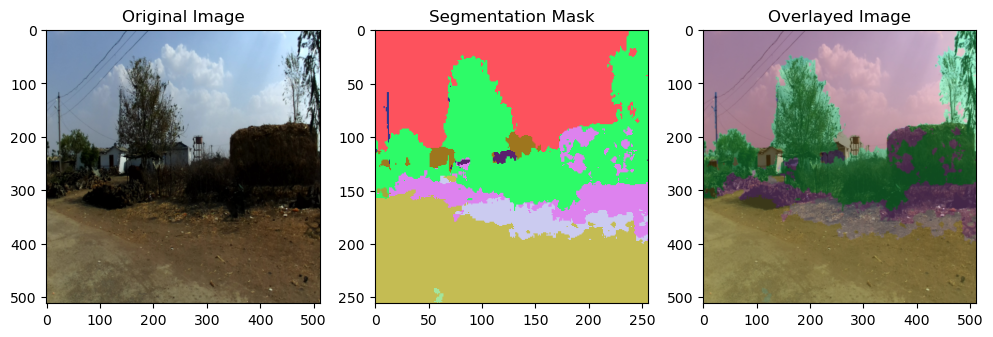

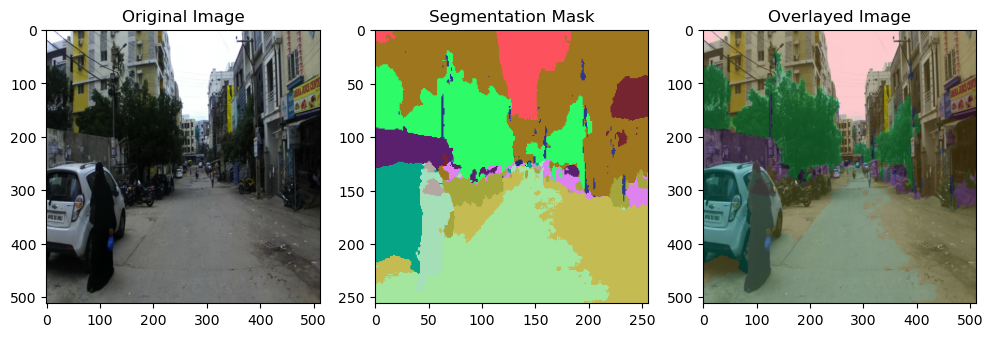

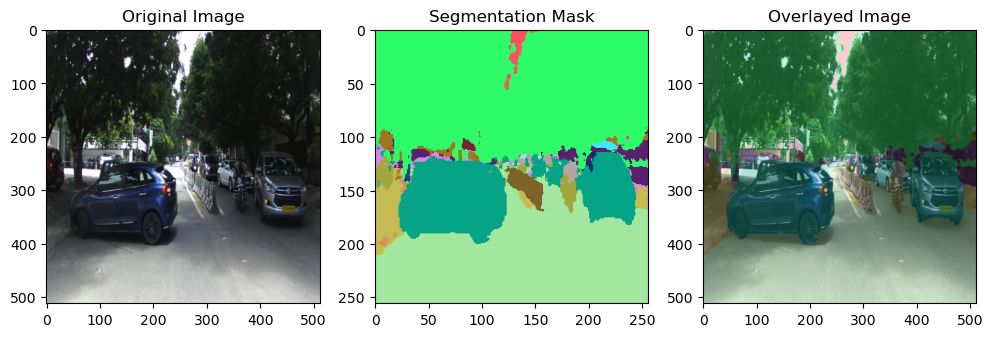

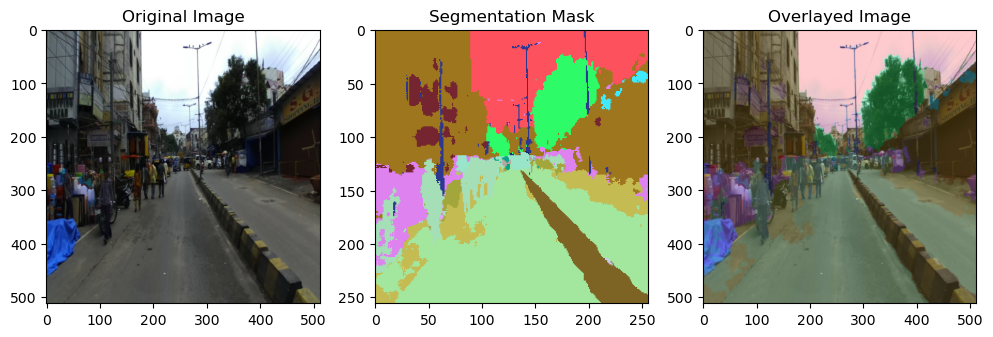

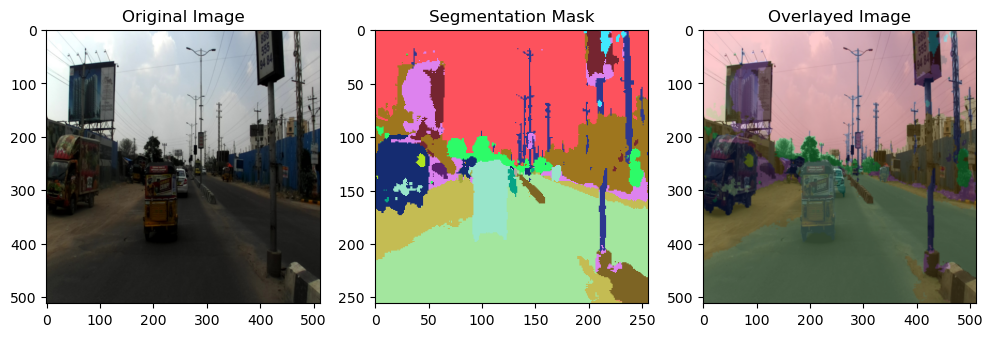

In [23]:
#some visual results

with torch.no_grad():
    for data in test_loader:
        if visualization_count >= 5:
            break
        images, labels = data
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for img, pred in zip(images, predicted):
            if visualization_count >= 5:
                break


            img_pil = to_pil_image(img.cpu())
            pred_np = pred.cpu().numpy()


            color_mask = decode_segmentation_masks(pred_np, COLOR_MAP, n_classes)


            overlayed_img = overlay_mask(np.array(img_pil), color_mask, alpha=0.7)

            # Display the original image, segmentation mask, and overlayed image
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img_pil)
            plt.title('Original Image')

            plt.subplot(1, 3, 2)
            plt.imshow(color_mask)
            plt.title('Segmentation Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(overlayed_img)
            plt.title('Overlayed Image')
            plt.show()
            visualization_count += 1

In [24]:
valid_labels = np.array(all_labels)
valid_predictions = np.array(all_predicted)

# Calculate precision, recall, and F1 score
precision = precision_score(valid_labels, valid_predictions, average='macro', zero_division=1)
recall = recall_score(valid_labels, valid_predictions, average='macro', zero_division=1)
f1 = f1_score(valid_labels, valid_predictions, average='macro')

# Calculate and print loss and accuracy
test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / total
print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.0f}%)')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
classification_rep = classification_report(valid_labels, valid_predictions, zero_division=1)
print("Classification Report:")
print(classification_rep)


Test set: Average loss: 0.1303, Accuracy: 55274622/66584576 (83%)
Precision: 0.6827, Recall: 0.5231, F1 Score: 0.5333
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94  16716294
           1       0.66      0.80      0.72   4063060
           2       0.62      0.56      0.59    209395
           3       0.54      0.56      0.55    966046
           4       0.59      0.67      0.62    647699
           5       0.71      0.52      0.60    448535
           6       0.71      0.80      0.75    875874
           7       0.38      0.06      0.10     23437
           8       0.79      0.81      0.80    949721
           9       0.87      0.84      0.85   1505188
          10       0.54      0.61      0.58    761102
          11       0.42      0.57      0.49    235629
          12       0.65      0.08      0.15    262711
          13       0.82      0.79      0.80    948792
          14       0.44      0.51      0.47    

## 5. Result
After fifteen rounds of rigorous training, my model has commendably achieved an accuracy of 86.5%. When evaluated against the test set, the accuracy stands at a solid 83%. The precision metric is at 0.6827, with a recall of 0.5231, and an F1 Score of 0.5333.

In addition to these metrics, I have ventured into the realm of visualization to further analyze the model's performance. By assigning a spectrum of colors to the identified masks and overlaying them onto the original images, I observed a promising delineation of the segmented areas. The results are visually impactful and indicate a successful segmentation effort.

Despite the model not being pre-trained, securing an 83% accuracy is commendable. However, when juxtaposed with the 90+ accuracy achieved by pre-trained networks like ResNet18 and ResNet50, there's an evident gap that beckons improvement.

## 6. Discussion
The classification report reveals high recognition rates for classes 0 and 25, while classes 7, 12, and 19 lag behind—potentially an artifact of class imbalance. Due to the dataset specifying that the pixel label of 255 should be considered as class 26,marked as uninterested and ignored, it scores  high in precision.

The model exhibits strong segmentation capabilities for road conditions even without pre-training. Secondly, a comprehensive performance evaluation was conducted, providing detailed insights across all 27 classes.

However, the training process was slow, possibly due to inadequate preprocessing or a small batch size. Additionally, the slow decline in loss values could be attributed to suboptimal learning rate adjustments. The model solely relied on a simple Adam optimizer without incorporating strategies like stochastic gradient descent with momentum or early stopping.

The approach to data augmentation also fell short, lacking extensive flips and transformations that could have enriched the model's robustness. A two-stage training process was not employed, and a refinement of the weights across all layers was absent from the methodology.

These areas, if addressed, could potentially enhance the model's accuracy and efficiency, propelling it closer to the benchmarks set by its pre-trained counterparts.

Future work is to fine-tune the learning rate adaptively, gradient-based adjustments can be implemented, which would alter the learning rate in response to the changes in the gradient of the loss function over epochs.Employing early stopping is another strategic maneuver, where training is halted as soon as the model's performance on the validation set ceases to improve.Moreover, harnessing a more extensive set of data augmentation techniques is crucial. By introducing a variety of transformations such as random rotations, flips, scaling, and translations, the model can learn from a more diverse and representative sample of the data distribution. 